In [2]:
import os
import sys
import numpy as np

In [3]:
from skimage import data, io, filters
import matplotlib.pyplot as plt

In [161]:
# dimensions of result image
W = 1200
H = 900
CHANNEL_NUM = 3  # we work with rgb images
MAX_VALUE = 255  # max pixel value, required by ppm header
MATHEMATICAL_ERROR = 0.006 #maximum error between the boundaries of the tiles
NUMBER_SIDE_TILES = 4

In [5]:
def read_image(path):
    # second line of header contains image dimensions
    w, h = np.loadtxt(path, skiprows=1, max_rows=1, dtype=np.int32)
    # skip 3 lines reserved for header and read image
    image = np.loadtxt(path, skiprows=3, dtype=np.uint8).reshape((h, w, CHANNEL_NUM))
    return image

In [6]:
def write_image(path, img):
    h, w = img.shape[:2]
    # ppm format requires header in special format
    header = f'P3\n{w} {h}\n{MAX_VALUE}\n'
    with open(path, 'w') as f:
        f.write(header)
        for r, g, b in img.reshape((-1, CHANNEL_NUM)):
            f.write(f'{r} {g} {b} ')

In [91]:
def sum_side_pixels(tile, h, w):
    sum_side_pixels = np.zeros([4, 3])
    sum_side_pixels[:] = 0
    for i in range(CHANNEL_NUM):
        #вверх тайла
        sum_side_pixels[0][i] += (np.array(tile[0,:,i])).sum()
        #низ тайла
        sum_side_pixels[1][i] += (np.array(tile[h-1,:,i])).sum()
        #левый бок тайла
        sum_side_pixels[2][i] += (np.array(tile[:,0,i])).sum()
        #правый бок тайла
        sum_side_pixels[3][i] += (np.array(tile[:,w-1,i])).sum()
    return sum_side_pixels


In [112]:
def sum_side_pixels_up(tile):
    sum_side_pixels = 0
    for i in range(CHANNEL_NUM):
        sum_side_pixels += (tile[0,:,i]).sum()
    return sum_side_pixels


In [165]:
def sum_side_pixels_down(tile, h):
    sum_side_pixels = 0
    for i in range(CHANNEL_NUM):
        sum_side_pixels += (tile[h-1,:,i]).sum()
    return sum_side_pixels


In [143]:
def sum_side_pixels_left(tile):
    sum_side_pixels = 0
    for i in range(CHANNEL_NUM):
      sum_side_pixels += (tile[:,0,i]).sum()
    return sum_side_pixels


In [157]:
def sum_side_pixels_right(tile, w):
    sum_side_pixels = 0
    for i in range(CHANNEL_NUM):
        sum_side_pixels += (tile[:,w-1,i]).sum()      
    return sum_side_pixels  


In [163]:
def find_neighbors_new(find_tile, tiles, h, w, side_find_tile):
    # если side_find_tile = 0 - верхняя сторона, 1 - нижняя сторона, 2 - левая сторона, 3 - правая сторона 
    # проверить соседа 4 тайла с 10
    if side_find_tile == 0:
        sum_side_find_tile = sum_side_pixels_up(tiles[find_tile])
    elif side_find_tile == 1:
        sum_side_find_tile = sum_side_pixels_down(tiles[find_tile], h)
    elif side_find_tile == 2:
        sum_side_find_tile = sum_side_pixels_left(tiles[find_tile])
    else:
        sum_side_find_tile = sum_side_pixels_right(tiles[find_tile], w)

    neighbors_tile = np.zeros(2)
    neighbors_tile[:] = -1
    min_error = 1
    
    for i in range(len(tiles)):
        if i == find_tile:
            continue;
        #ищем минимальную погрешность между пикселями граней тайлов
        error_up = (np.abs((sum_side_find_tile - sum_side_pixels_up(tiles[i]))) / sum_side_find_tile).sum()
        error_down = (np.abs((sum_side_find_tile - sum_side_pixels_down(tiles[i], h))) / sum_side_find_tile).sum()
        error_left = (np.abs((sum_side_find_tile - sum_side_pixels_left(tiles[i]))) / sum_side_find_tile).sum()
        error_right = (np.abs((sum_side_find_tile - sum_side_pixels_right(tiles[i], w))) / sum_side_find_tile).sum()
        #print(i, error_up, error_down, error_left, error_right, sep='\n', end='\n next \n')
        if (min_error > error_up):
            min_error = error_up
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 0

        if min_error > error_down :
            min_error = error_down
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 1

        if (min_error > error_left):
            min_error = error_left
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 2

        if (min_error > error_right):
            min_error = error_right
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 3

    return neighbors_tile

In [43]:
def find_neighbors(find_tile, tiles, h, w):
  
    sum_side_find_tile = sum_side_pixels(tiles[find_tile], h, w)
    neighbors_tile = np.zeros([2, 4])
    neighbors_tile[:] = -1

    for i in range(len(tiles)):
      if i == find_tile:
        continue;
      min_error_up = 1
      min_error_down = 1
      min_error_left = 1
      min_error_right = 1
      sum_side_tiles = sum_side_pixels(tiles[i], h, w)
      for j in range(NUMBER_SIDE_TILES):
        #ищем минимальную погрешность между пикселями граней тайлов
        error_up = (np.abs((sum_side_find_tile[0] - sum_side_tiles[j])) / sum_side_find_tile[0]).sum()
        error_down = (np.abs((sum_side_find_tile[1] - sum_side_tiles[j])) / sum_side_find_tile[1]).sum()
        error_left = (np.abs((sum_side_find_tile[2] - sum_side_tiles[j])) / sum_side_find_tile[2]).sum()
        error_right = (np.abs((sum_side_find_tile[3] - sum_side_tiles[j])) / sum_side_find_tile[3]).sum()
        #print(i, error_up, error_down, error_left, error_right, sep='\n', end='\n next \n')
        if (min_error_up > error_up):
          min_error_up = error_up
          if (min_error_up <= MATHEMATICAL_ERROR):
            neighbors_tile[0][0] = i
            neighbors_tile[1][0] = j

        if min_error_down > error_down :
          min_error_down = error_down
          if (min_error_down <= MATHEMATICAL_ERROR):
            neighbors_tile[0][1] = i
            neighbors_tile[1][1] = j

        if (min_error_left > error_left):
          min_error_left = error_left
          if (min_error_left <= MATHEMATICAL_ERROR):
            neighbors_tile[0][2] = i
            neighbors_tile[1][2] = j

        if (min_error_right > error_right):
          min_error_right = error_right
          if (min_error_right <= MATHEMATICAL_ERROR):
            neighbors_tile[0][3] = i
            neighbors_tile[1][3] = j

    #проверить вручную соседей 5 и 2
    # sum_side_tiles = sum_side_pixels(tiles[5], h, w)
    # for j in range(NUMBER_SIDE_TILES):
    #  error_up = (np.abs((sum_side_find_tile[0] - sum_side_tiles[j])) / sum_side_find_tile[0]).sum()
    #  error_down = (np.abs((sum_side_find_tile[1] - sum_side_tiles[j])) / sum_side_find_tile[1]).sum()
    #  error_left = (np.abs((sum_side_find_tile[2] - sum_side_tiles[j])) / sum_side_find_tile[2]).sum()
    #  error_right = (np.abs((sum_side_find_tile[3] - sum_side_tiles[j])) / sum_side_find_tile[3]).sum()
    #  print(j, error_up, error_down, error_left, error_right, sep='\n', end='\n next \n')

    # sum_side_tiles = sum_side_pixels(tiles[5], h, w)
    # error_down = (np.abs((sum_side_find_tile[1] - sum_side_tiles[2])) / sum_side_find_tile[1]).sum()
    # print(error_down)
      
    #print(sum_side_find_tile)
      #print()
      #print(np.array((find_tile[0:3][0:3][0])[:][0][:]))

    # #вывод фрагментов
    # image = (tiles[3])
    # plt.imshow(image)
    # plt.savefig("image.png")

    return neighbors_tile


In [77]:
def neighborhood_compilation(first_tile_i, neighbors_tile, tiles, number_of_tiles_in_a_row):
    # выставляем соседей в правильном порядке
    
    #ставим соседа справа
    # if neighbors_tile[1][3] != -1:
    #    temp = np.array(tiles[int( neighbors_tile[0][3])])

    #    #переворот правого соседа
    #    if (neighbors_tile[1][3] == 3):
    #      temp = np.rot90(temp, 2)
    #    elif (neighbors_tile[1][3] == 1):
    #      temp = np.rot90(temp, 3)
    #    elif (neighbors_tile[1][3] == 0):
    #      temp = np.rot90(temp, 1)

    #    tiles[int( neighbors_tile[0][3])] = tiles[int( first_tile_i + 1 )]
    #    tiles[int( first_tile_i + 1 )] = temp

      # ставим соседа слева
    if neighbors_tile[1][2] != -1:
        # смещение тайлов
        if first_tile_i % number_of_tiles_in_a_row == 0:
            temp = np.array(tiles[first_tile_i])
            tiles[first_tile_i] = tiles[first_tile_i+1]
            tiles[first_tile_i+1] = temp
            temp = np.array(tiles[int(neighbors_tile[0][2])])
            tiles[int(neighbors_tile[0][2])] = tiles[first_tile_i]
            tiles[first_tile_i] = temp
            temp = np.array([first_tile_i])
        else:
            temp = np.array(tiles[int(neighbors_tile[0][2])])
            tiles[int(neighbors_tile[0][2])] = tiles[first_tile_i-1]
            tiles[first_tile_i-1] = temp


        #переворот левого соседа
        if (neighbors_tile[1][2] == 2):
            tiles[first_tile_i-1] = np.rot90(tiles[first_tile_i-1], 2)
        elif (neighbors_tile[1][2] == 1):
            tiles[first_tile_i-1] = np.rot90(tiles[first_tile_i-1], 1)
        elif (neighbors_tile[1][2] == 0):
            tiles[first_tile_i-1] = np.rot90(tiles[first_tile_i-1], 3)
        


            # tiles[int(neighbors_tile[0][3])] = tiles[int( first_tile_i + 1 )]
            # tiles[int(first_tile_i)] = temp
       
      #  image = (temp)
      #  plt.imshow(image)
      #  plt.savefig("image.png")

    #print(first_tile)
    return tiles

In [221]:
def left_neighborhood_compilation(first_tile_i, neighbors_tile, tiles):
    # смещение тайлов
    # доделать смещение влево нормально
    #temp = np.array(tiles[int( neighbors_tile[0])])


    temp = np.array(tiles[first_tile_i])
    tiles[first_tile_i] = tiles[int(neighbors_tile[0])]
    tiles[int(neighbors_tile[0])] = temp 
    temp = np.array(tiles[int(neighbors_tile[0])])
    tiles[int(neighbors_tile[0])] = tiles[first_tile_i+1]
    tiles[first_tile_i+1] = temp

    #переворот левого соседа
    if (neighbors_tile[1] == 2):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 2)
    elif (neighbors_tile[1] == 1):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 1)
    elif (neighbors_tile[1] == 0):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 3)

    return tiles

In [216]:
def right_neighborhood_compilation(first_tile_i, neighbors_tile, tiles):
    #ставим соседа справа
    temp = np.array(tiles[int( neighbors_tile[0])])

    #переворот правого соседа
    if (neighbors_tile[1] == 3):
        temp = np.rot90(temp, 2)
    elif (neighbors_tile[1] == 1):
        temp = np.rot90(temp, 3)
    elif (neighbors_tile[1] == 0):
        temp = np.rot90(temp, 1)

    tiles[int( neighbors_tile[0])] = tiles[int( first_tile_i + 1 )]
    tiles[int( first_tile_i + 1 )] = temp
    
    return tiles

In [214]:
def solve_puzzle(tiles_folder):
    # create placeholder for result image
    # read all tiles in list
    tiles = [read_image(os.path.join(tiles_folder, t)) for t in sorted(os.listdir(tiles_folder))]
    
    tiles = np.array(tiles)
    #tiles_copy = np.array(tiles)

    result_img = np.zeros((H, W, CHANNEL_NUM), dtype=np.uint8)
    # scan dimensions of all tiles and find minimal height and width
    dims = np.array([t.shape[:2] for t in tiles])
    h, w = np.min(dims, axis=0)

    # compute grid that will cover image
    # spacing between grid rows = min h
    # spacing between grid columns = min w
    x_nodes = np.arange(0, W, w)
    y_nodes = np.arange(0, H, h)
    xx, yy = np.meshgrid(x_nodes, y_nodes)
    nodes = np.vstack((xx.flatten(), yy.flatten())).T

    #Расположение тайлов в правильном порядке
    number_of_tiles_in_a_row = W // w
    number_of_tiles_in_a_column = H // h
    #location_tiles = np.zeros([number_of_tiles_in_a_column, number_of_tiles_in_a_row])
      
    # neighbors_tile = find_neighbors_new(0, tiles, h, w, 2)
    # tiles = left_neighborhood_compilation(0, neighbors_tile, tiles, number_of_tiles_in_a_row)

    for j in range(number_of_tiles_in_a_column):
        # сосед слева
        neighbors_tile = find_neighbors_new(0+j *number_of_tiles_in_a_row, tiles, h, w, 2)
        right_tile_i = 0
        while neighbors_tile[0] != -1 and right_tile_i + j * number_of_tiles_in_a_row < number_of_tiles_in_a_row + j * number_of_tiles_in_a_row - 1:
            print(0+j *number_of_tiles_in_a_row, neighbors_tile, end='\n\n')
            right_tile_i += 1
            tiles = left_neighborhood_compilation(j*number_of_tiles_in_a_row , neighbors_tile, tiles)
            neighbors_tile = find_neighbors_new(0+j *number_of_tiles_in_a_row, tiles, h, w, 2)
        # сосед справа
        # neighbors_tile = find_neighbors_new(0+j *number_of_tiles_in_a_row, tiles, h, w, 3)
        neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)
        while neighbors_tile[0] != -1 and right_tile_i + j * number_of_tiles_in_a_row < number_of_tiles_in_a_row * number_of_tiles_in_a_column - 1: 
            print(0+j *number_of_tiles_in_a_row, neighbors_tile, end='\n\n')
            tiles = right_neighborhood_compilation(right_tile_i+j*number_of_tiles_in_a_row , neighbors_tile, tiles)
            right_tile_i += 1
            neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)


    # for j in range(number_of_tiles_in_a_column):
    #   for i in range(number_of_tiles_in_a_row):
    #       neighbors_tile = find_neighbors(i+j*number_of_tiles_in_a_row, tiles, h, w)
    #       print(neighbors_tile, end='\n\n')
    #       tiles = neighborhood_compilation(i+j*number_of_tiles_in_a_row , neighbors_tile, tiles, number_of_tiles_in_a_row)

    # fill grid with tiles
    for (x, y), tile in zip(nodes, tiles):
        result_img[y: y + h, x: x + w] = tile[:h, :w]
 
    output_path = "image_output.ppm"
    write_image(output_path, result_img)

In [218]:
if __name__ == "__main__":
    #directory = sys.argv[1]
    directory = "drive/MyDrive/3Divi/data/0000_0000_0000/tiles"
    solve_puzzle(directory)

0 [4. 0.]

0 [11.  3.]

0 [5. 2.]

8 [1. 1.]

8 [6. 0.]

8 [0. 0.]



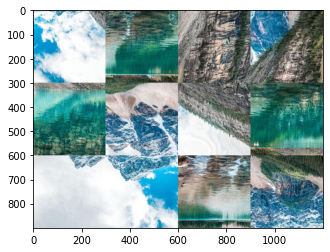

In [220]:
image = read_image("image_output.ppm")
#edges = filters.sobel(image)
#io.imshow(edges)
#io.show()
plt.imshow(image)
plt.savefig("image.png")

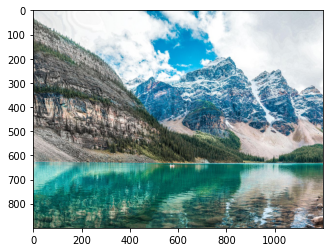

In [13]:
image = read_image("drive/MyDrive/3Divi/data/0000_0000_0000/image.ppm")
#edges = filters.sobel(image)
#io.imshow(edges)
#io.show()
plt.imshow(image)
plt.savefig("image_check.png")